https://todayisbetterthanyesterday.tistory.com/56

### ↑ Shap value 설명 참고 

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# 현재경로 확인
os.getcwd()

'C:\\Users\\user\\TEST3'

In [3]:
# 데이터 불러오기
df = pd.read_csv("C:/Users/user/TEST3/csv파일/데이터셋_4(EPDO1).csv",encoding='cp949') 
df.head() # 데이터 확인

,사고유형,연령가해자,법규위반가해자,행동유형가해자,피해자신체상해주부위,차량용도가해자,도로종류,도로형태,도로선형,발생시각,EPDO1
0,횡단중,65세이상,그룹1,그룹2,그룹5,그룹4,시도,단일로,평지,출퇴근시간,32
1,횡단중,51-60세,그룹1,그룹3,그룹4,그룹1,시도,교차로,평지,저녁~자정,32
2,길가장자리구역통행중,31-40세,그룹1,그룹3,그룹3,그룹4,시도,단일로,평지,낮,32
3,횡단중,41-50세,그룹1,그룹2,그룹4,그룹1,시도,단일로,평지,출퇴근시간,32
4,횡단중,51-60세,그룹2,그룹3,그룹4,그룹1,시도,교차로,평지,낮,32


In [6]:
x=df.drop(['EPDO1'],axis=1)
x=pd.get_dummies(x,drop_first=True)
y=pd.DataFrame(df['EPDO1'])
data = pd.concat([x,y],axis=1)

In [7]:
# shape 파악
nCar = data.shape[0] # 데이터 개수
nVar = data.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 27284 nVar: 36


In [8]:
feature_columns = list(data.columns.difference(['EPDO1'])) # price-target, 그 외 feature
X = data[feature_columns]
y = data['EPDO1']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42) 
# train/test 비율을 7:3
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) # 데이터 확인

(19098, 35) (8186, 35) (19098,) (8186,)


In [9]:
# lightgbm을 구현하여 shap value를 예측할 것
# ligthgbm 구현

# library
import lightgbm as lgb  # 없을 경우 cmd/anaconda prompt에서 install
from math import sqrt
from sklearn.metrics import mean_squared_error

# lightgbm model
lgb_dtrain = lgb.Dataset(data = train_x, label = train_y) # LightGBM 모델에 맞게 변환
lgb_param = {'max_depth': 10,
            'learning_rate': 0.01, # Step Size
            'n_estimators': 1000, # Number of trees
            'objective': 'regression'} # 목적 함수 (L2 Loss)
lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain) # 학습 진행
lgb_model_predict = lgb_model.predict(test_x) # test data 예측
print("RMSE: {}".format(sqrt(mean_squared_error(lgb_model_predict, test_y)))) # RMSE

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 19098, number of used features: 35
[LightGBM] [Info] Start training from score 46.286784
RMSE: 67.29534588898754


In [10]:
#shap value를 이용하여 각 변수의 영향도 파악

# shap value 
import shap
explainer = shap.TreeExplainer(lgb_model) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(test_x) # Shap Values 계산

In [11]:
# version 확인
import skimage
skimage.__version__

'0.17.2'

In [12]:
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values[1,:], test_x.iloc[1,:])

In [13]:
import matplotlib.pyplot as plt
# 한글 폰트 깨지는 것 때문에 추가함
import matplotlib
from matplotlib import font_manager, rc
import platform

matplotlib.rcParams['axes.unicode_minus'] = False

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)


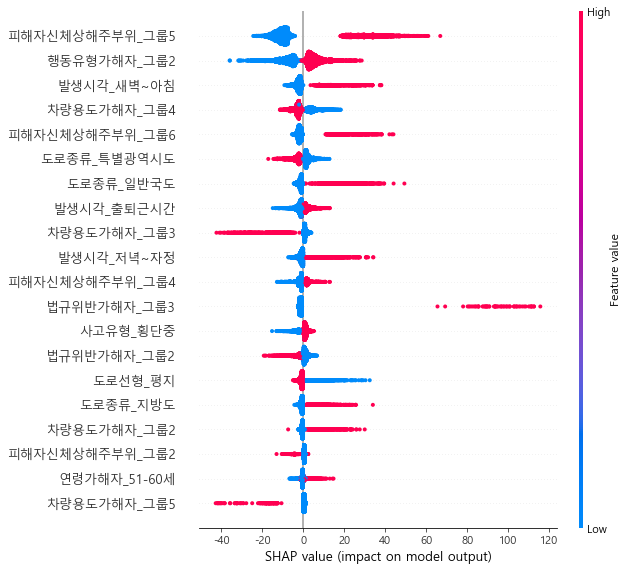

In [14]:
# summary 
fig = shap.summary_plot(shap_values, test_x,show=False)
plt.savefig('scratch.png')

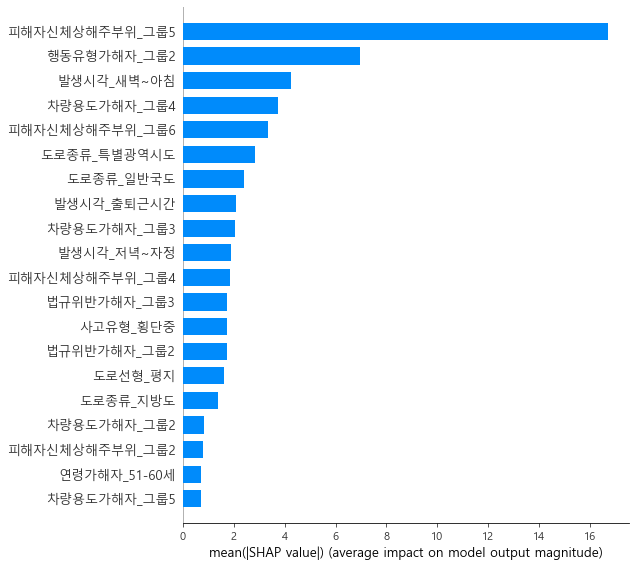

In [15]:
 # 각 변수에 대한 |Shap Values|을 통해 변수 importance 파악
shap.summary_plot(shap_values, test_x, plot_type = "bar")